In [1]:
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
from scipy.optimize import minimize_scalar

In [2]:
params = {'font.size': 16,
          'axes.labelsize': 'large'}

plt.rcParams.update(**params)

## Read data

In [4]:
df = pd.read_json('data/angle_dimer_fits_101520.json')

n_p = df.n_p
a_p = df.a_p
theta = df.theta
d_fit = 2. * df['a_p^*']
n_fit = df['n_p^*']

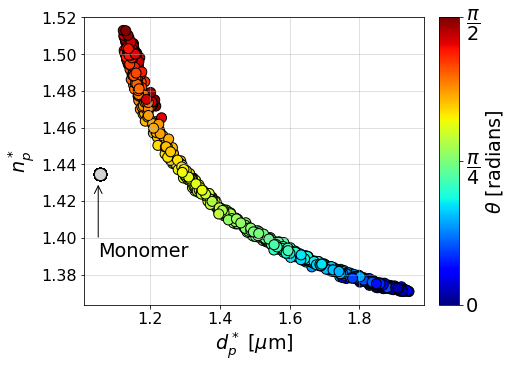

In [5]:
fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)

ax.scatter(2*a_p, n_p, color='lightgray', ec='k', s=150)
ax.annotate('Monomer', xy=(1.05, 1.43), xytext=(1.05, 1.39), arrowprops={'arrowstyle': '->', 'relpos': (0,1)}, fontsize='large')

ct = ax.scatter(d_fit, n_fit, s=100, c = theta, cmap='jet', ec='black', vmin=0, vmax=np.pi/2)

ax.set_xlabel('$d_p^*$ [$\mu$m]')
ax.set_ylabel('$n_p^*$')

cb = fig.colorbar(ct, ax=ax, ticks=[0, np.pi/4, np.pi/2])
cb.set_label(r'$\theta$ [radians]')
cb.ax.set_yticklabels(['0', r'$\dfrac{\pi}{4}$', r'$\dfrac{\pi}{2}$'])
cb.ax.tick_params(labelsize='large')

ax.grid(alpha=0.5)

## Orientation dependence of properties ##
### Phenomenological model:
Polynomial in $\sin^2(\theta)$

        3          2
0.5196 x - 0.6648 x - 0.6116 x + 1.894
         3           2
0.07779 x + 0.02245 x + 0.03122 x + 1.373


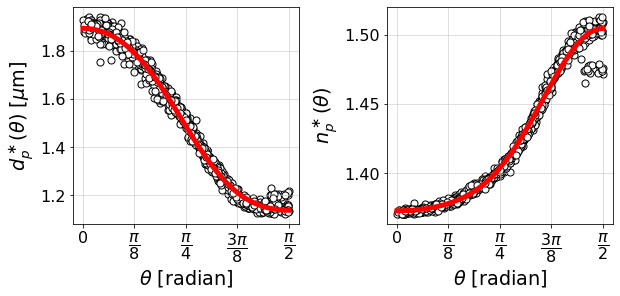

In [6]:
def model(theta, poly):
    return poly(np.sin(theta)**2)

dpoly = np.poly1d(np.polyfit(np.sin(theta)**2, d_fit, 3))
npoly = np.poly1d(np.polyfit(np.sin(theta)**2, n_fit, 3))

th = np.linspace(0, np.pi/2.)
d_m = model(th, dpoly)
n_m = model(th, npoly)

fig, (axa, axb) = plt.subplots(ncols=2, figsize=(8.5,4), constrained_layout=True)

sstyle = dict(color='w', edgecolor='k', s=50)

axa.scatter(theta, d_fit, **sstyle)
axa.plot(th, d_m, color='r', linewidth=5)
axa.set_ylabel(r'$d_p^\ast(\theta)$ [$\mu$m]')

axb.scatter(theta, n_fit, **sstyle)
axb.plot(th, n_m, color='r', linewidth=5)
axb.set_ylabel(r'$n_p^\ast(\theta)$')

for ax in (axa, axb):
    ax.set_xlabel(r'$\theta$ [radian]')
    ax.set_xticks([0, np.pi/8, np.pi/4, 3*np.pi/8., np.pi/2.])
    ax.set_xticklabels(['0', r'$\dfrac{\pi}{8}$', r'$\dfrac{\pi}{4}$', r'$\dfrac{3\pi}{8}$', r'$\dfrac{\pi}{2}$'])
    ax.grid(alpha=0.5)
    
print(dpoly)
print(npoly)

fig.savefig('dimerfits04.pdf', dpi=300, facecolor='w')

## Fit parametric curve to sigmoids

Note: here I do not use $\theta_1 = \theta_2$ (yet?)

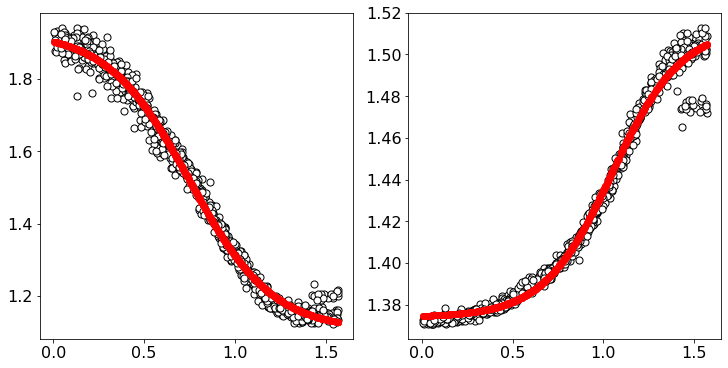

In [7]:
def sigmoid(x, L, x0, k, b):
    y = L / (1. + np.exp(-k*(x-x0))) + b
    return y

p0 = [max(d_fit), np.median(theta), 1, min(d_fit)] # this is an mandatory initial guess

popt_d, pcov = curve_fit(sigmoid, theta, d_fit, p0, method='dogbox')
d_model = sigmoid(theta, *popt_d)

fig, (axa, axb) = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)

axa.scatter(theta, d_fit, **sstyle)
axa.scatter(theta, d_model, color='r')

popt_n, pcov = curve_fit(sigmoid, theta, n_fit, p0, method='dogbox')
n_model = sigmoid(theta, *popt_n)

axb.scatter(theta, n_fit, **sstyle)
axb.scatter(theta, n_model, color='r');

## Plot parametric curves

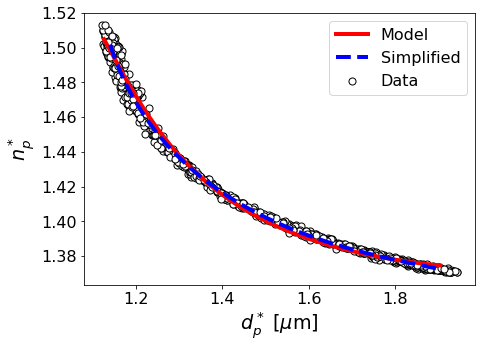

In [8]:
fig, ax = plt.subplots(figsize=(7,5))

d_model, n_model = zip(*sorted(zip(d_model, n_model)))

ax.scatter(d_fit, n_fit, label='Data', **sstyle)
ax.plot(d_model, n_model, c='r', label='Model', linewidth=4)
ax.plot(d_m, n_m, c='b', label='Simplified', linestyle='dashed', linewidth=4)
ax.legend()

ax.set_xlabel('$d_p^*$ [$\mu$m]')
ax.set_ylabel('$n_p^*$');

## For each data point, obtain closest value for $\theta$ based on our model

Minimize distance from the curve

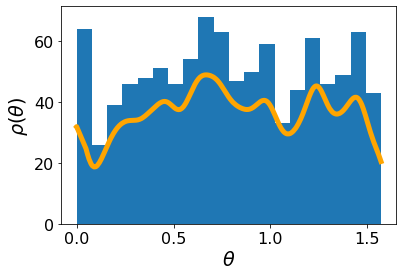

In [9]:
def makedistance(point):
    d0, n0 = point
    # drange = sigmoid(0., *popt_d) - sigmoid(np.pi/2., *popt_d)
    # nrange = sigmoid(np.pi/2., *popt_n) - sigmoid(0., *popt_n)
    drange = model(0., dpoly) - model(np.pi/2., dpoly)
    nrange = model(np.pi/2., npoly) - model(0., npoly)
    def distance(theta):
        # delta_d = d0 - sigmoid(theta, *popt_d)
        # delta_n = n0 - sigmoid(theta, *popt_n)
        delta_d = d0 - model(theta, dpoly)
        delta_n = n0 - model(theta, npoly)
        delta = np.sqrt((delta_d/drange)**2 + (delta_n/nrange)**2)
        return delta
    return distance

theta_fit = []
for i in range(len(d_fit)):
    point = (d_fit[i], n_fit[i])
    distance = makedistance(point)
    res = minimize_scalar(distance, bounds=(0, np.pi/2), method='bounded')
    theta_fit.append(res.x)

fig, ax = plt.subplots()
ax.hist(theta_fit, bins=20)
kernel_sim = stats.gaussian_kde(theta_fit, bw_method=0.1)
rho_sim = kernel_sim(np.sort(theta_fit))
ax.plot(np.sort(theta_fit), 60*rho_sim, color='orange', linewidth=5, label='KDE')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$');

## Load experimental data

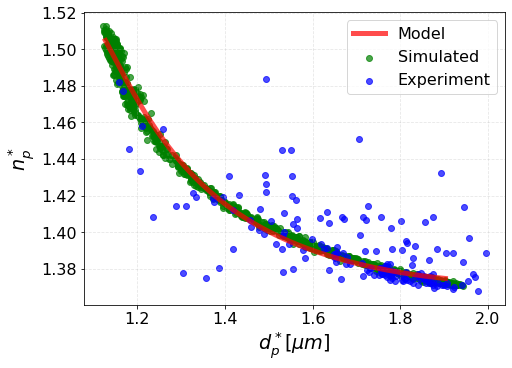

In [10]:
exp_data = pd.read_csv('data/cheong_separated02.csv')

exp_dimers = exp_data[exp_data['label'] == 'dimer']
exp_mono = exp_data[exp_data['label'] == 'monomer']
d_ex = exp_dimers.d_p
n_ex = exp_dimers.n_p
z_ex = exp_dimers.z_p

fig, ax = plt.subplots(figsize=(7,5), constrained_layout=True)

ax.scatter(d_fit, n_fit, c='g', label='Simulated', alpha=0.7)
ax.plot(d_model, n_model, c='r', label='Model', alpha=0.7, linewidth=5)
ax.scatter(d_ex, n_ex, c='b', label='Experiment', alpha=0.7)
ax.legend()
ax.set_xlabel('$d_p^* [\mu m]$')
ax.set_ylabel('$n_p^*$')
ax.grid(alpha=0.3, linestyle='dashed')

## Obtain experimental theta values using the same model

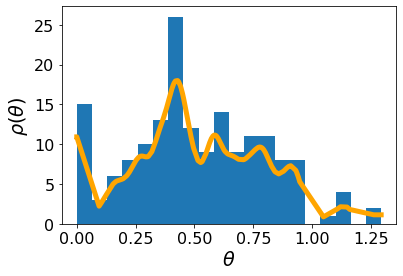

In [11]:
n_ex = np.array(n_ex)
d_ex = np.array(d_ex)

theta_ex = []
for i in range(len(d_ex)):
    point = (d_ex[i], n_ex[i])
    distance = makedistance(point)
    res = minimize_scalar(distance, bounds=(0, np.pi/2), method='bounded')
    theta_ex.append(res.x)
    
fig, ax = plt.subplots()
ax.hist(theta_ex, bins=20)
kernel_ex = stats.gaussian_kde(theta_ex, bw_method=0.1)
rho_ex = kernel_ex(np.sort(theta_ex))
ax.plot(np.sort(theta_ex), 9*rho_ex, color='orange', linewidth=5, label='KDE')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$');

## Plot both angular densities

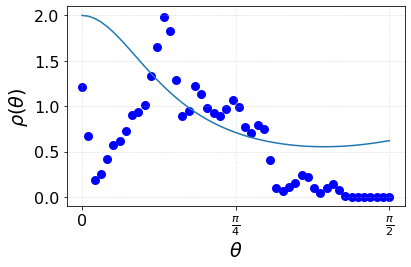

In [12]:
theta_run = np.linspace(0, np.pi/2, num=50)
rho_sim = kernel_sim(theta_run)
rho_ex = kernel_ex(theta_run)

rho_diff = [kernel_ex(x)/kernel_sim(x) for x in theta_run]

fig, ax = plt.subplots()
ax.scatter(theta_run, rho_ex, linewidth=3, c='b')
ax.set_xticks([0, np.pi/4, np.pi/2])
ax.set_xticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\rho(\theta)$')
fig.tight_layout()
ax.grid(alpha=0.3, linestyle='dashed')

def jeffery(theta, ratio=2):
    return ratio/(2.*np.pi*(ratio**2*np.sin(theta)**2 + np.cos(theta**2)))

ax.plot(theta_run, 2.*np.pi*jeffery(theta_run))

In [13]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

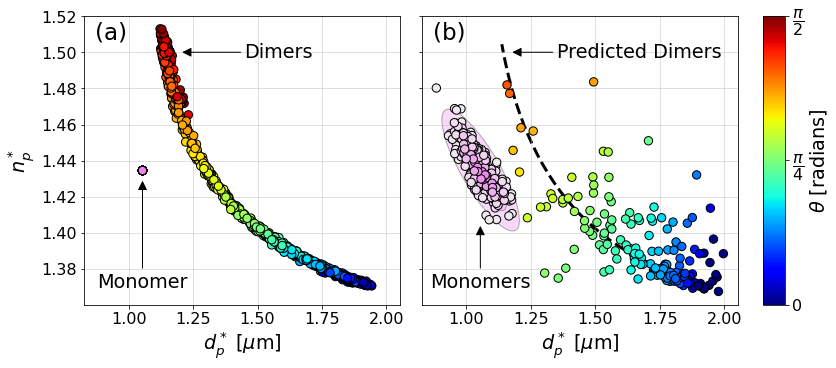

In [14]:
def make_colors(df, base_color):
    xy = np.vstack([df.d_p, df.n_p])
    rho = stats.gaussian_kde(xy)(xy)
    rho /= np.max(rho)
    hsv = np.tile(colors.rgb_to_hsv(colors.to_rgb(base_color)), (len(rho), 1))
    hsv[:,1] *= rho
    rgb = colors.hsv_to_rgb(hsv)
    return rgb

fig, axes = plt.subplots(1, 2, figsize=(11.5,5), sharey=True, sharex=True, constrained_layout=True)
ax1, ax2 = axes

ax1.scatter(2*a_p, n_p, color='violet', ec='k', s=70)
ax1.plot(d_m, n_m, c='k', linewidth=4, zorder=1, linestyle='--')
sp = ax1.scatter(d_fit, n_fit, s=70, c=theta, cmap='jet', ec='k', vmin=0, vmax=np.pi/2, zorder=2)

ax2.plot(d_m, n_m, c='k', linewidth=3, zorder=1, linestyle='--')
c = make_colors(exp_mono, 'violet')
ax2.scatter(exp_mono.d_p, exp_mono.n_p, s=70, c=c, ec='k', zorder=5)
style = dict(ec='k', fc='violet', alpha=0.3)
for n in range(3):
    confidence_ellipse(exp_mono.d_p, exp_mono.n_p, ax2, n_std=n+1, zorder=3-n, **style)
ax2.scatter(d_ex, n_ex, s=70, c=theta_ex, cmap='jet', ec='k', vmin=0, vmax=np.pi/2, zorder=2)

cb = fig.colorbar(sp, ax=axes, ticks=[0, np.pi/4, np.pi/2], aspect=30)
cb.set_label(r'$\theta$ [radians]')
cb.ax.set_yticklabels(['0', r'$\dfrac{\pi}{4}$', r'$\dfrac{\pi}{2}$'])

labels = ['(a)', '(b)']
for ax, label in zip(axes, labels):
    ax.grid(alpha=0.5)
    ax.text(0.87, 1.507, label, fontsize='x-large' )
    ax.set_xlabel(r'$d_p^*$ [$\mu$m]')
ax1.set_ylabel(r'$n_p^*$')

d_p = 1.054
astyle = {'arrowprops': {'arrowstyle': '-|>', 'color': 'k'}, 'fontsize': 'large'}
ax1.annotate('Monomer', xy=(d_p, 1.43), xytext=(d_p, 1.37), **astyle, ha='center')
ax1.annotate('Dimers', xy=(1.2, 1.5), xytext=(1.45, 1.5), **astyle, va='center')
ax2.annotate('Monomers', xy=(d_p, 1.405), xytext=(d_p, 1.37), **astyle, ha='center')
ax2.annotate('Predicted Dimers', xy=(1.17, 1.5), xytext=(1.35, 1.5), **astyle, va='center')

fig.savefig('orientation04.pdf', dpi=300, facecolor='w')

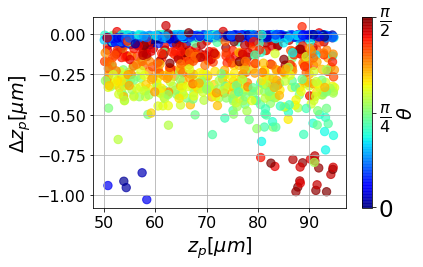

In [16]:
z_fit = df['z_p^*']*0.120

zdiff = z_fit - df.z_p

fig, ax = plt.subplots()
scatter = ax.scatter(df.z_p, zdiff, s=70, c=df.theta, cmap='jet', alpha=0.7)
#ax.plot(df.z_p, df.z_p, c='r')
cb = fig.colorbar(scatter, ax=ax, ticks=[0.01, np.pi/4, np.pi/2-0.001])
cb.ax.tick_params(labelsize='x-large')
cb.set_label(r'$\theta$')
cb.ax.set_yticklabels(['0', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax.set_xlabel(r'$z_p [\mu m]$')
ax.set_ylabel(r'$\Delta z_p [\mu m]$')
ax.grid()
fig.tight_layout()
fig.savefig('z_error02.png')